In [36]:
# imports

import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from items import Item
from loaders import ItemLoader
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import pickle

In [2]:
# load config

load_dotenv()
os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')

In [3]:
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
%matplotlib inline

In [5]:
# Load in our dataset

dataset = load_dataset('McAuley-Lab/Amazon-Reviews-2023', f"raw_meta_Appliances", split="full", trust_remote_code=True)

In [6]:
items = ItemLoader("Appliances").load(workers=8)

Loading dataset Appliances


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:20<00:00,  4.70it/s]


Completed Appliances with 28,625 datapoints in 0.4 mins


In [7]:
# Look for a familiar item..

print(items[1])
print('\nPrompt: ')
print(items[1].prompt)

<WP67003405 67003405 Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces AP6010352 8208254 PS11743531 - Quick DIY Repair Solution = $16.52>

Prompt: 
How much does this cost to the nearest dollar?

Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces - Quick DIY Repair Solution
Pivot Block For Vernicle Mullion Strip On Door - A high-quality exact equivalent for part numbers and Compatibility with major brands - Door Guide is compatible with Whirlpool, Amana, Dacor, Gaggenau, Hardwick, Jenn-Air, Kenmore, KitchenAid, and Maytag. Quick DIY repair - Refrigerator Door Guide Pivot Block Replacement will help if your appliance door doesn't open or close. Wear work gloves to protect your hands during the repair process. Attentive support - If you are uncertain about whether the block fits your refrigerator, we will help. We generally put forth a valiant effort to guarantee you are totally

Price is $17.00


## Now to SCALE UP

In [8]:
dataset_names = [
    "Automotive",
    "Electronics",
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games",
    "Office_Products",
    "Appliances",
    "Musical_Instruments",
]

In [9]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load(workers=8))

Loading dataset Automotive


100%|██████████████████████████████████████████████████████████████████████████████| 2004/2004 [05:35<00:00,  5.97it/s]


Completed Automotive with 911,688 datapoints in 5.9 mins
Loading dataset Electronics


100%|██████████████████████████████████████████████████████████████████████████████| 1611/1611 [04:10<00:00,  6.42it/s]


Completed Electronics with 443,473 datapoints in 4.4 mins
Loading dataset Office_Products


100%|████████████████████████████████████████████████████████████████████████████████| 711/711 [01:45<00:00,  6.77it/s]


Completed Office_Products with 240,394 datapoints in 1.9 mins
Loading dataset Tools_and_Home_Improvement


100%|██████████████████████████████████████████████████████████████████████████████| 1474/1474 [03:53<00:00,  6.32it/s]


Completed Tools_and_Home_Improvement with 541,051 datapoints in 4.1 mins
Loading dataset Cell_Phones_and_Accessories


100%|██████████████████████████████████████████████████████████████████████████████| 1289/1289 [02:25<00:00,  8.84it/s]


Completed Cell_Phones_and_Accessories with 238,869 datapoints in 2.6 mins
Loading dataset Toys_and_Games


100%|████████████████████████████████████████████████████████████████████████████████| 891/891 [02:03<00:00,  7.21it/s]


Completed Toys_and_Games with 340,479 datapoints in 2.2 mins
Loading dataset Appliances


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:20<00:00,  4.63it/s]


Completed Appliances with 28,625 datapoints in 0.4 mins
Loading dataset Musical_Instruments


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:31<00:00,  6.83it/s]


Completed Musical_Instruments with 66,829 datapoints in 0.6 mins


In [10]:
print(f"A grand total of {len(items):,} items")

A grand total of 2,811,408 items


In [20]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({
    'figure.figsize': (15, 6),
    'font.size': 10,
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Arial', 'Helvetica'],
})
%matplotlib inline

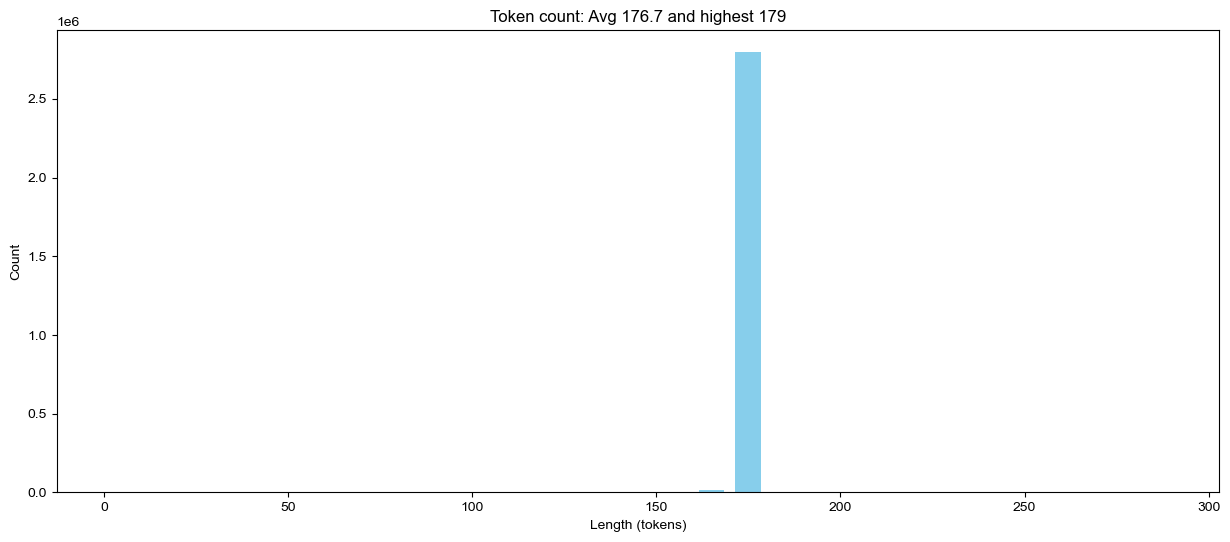

In [21]:
# Plot the distribution of token counts again

tokens = [item.token_count for item in items]
plt.figure(figsize=(15,6))
plt.title(f"Token count: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0,300,10))
plt.show()

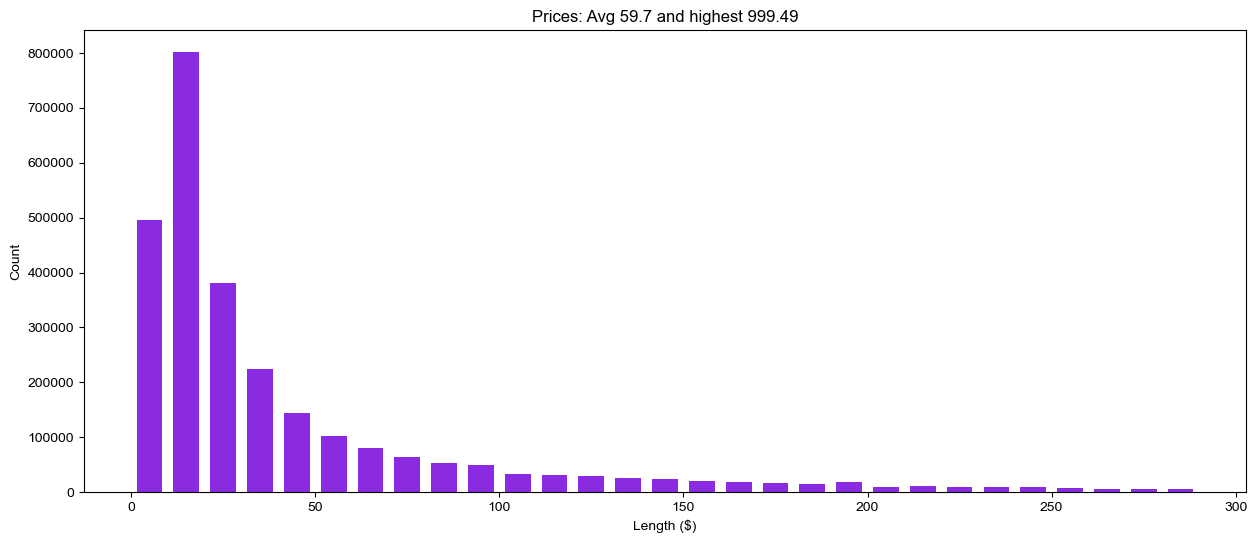

In [25]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15,6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}")
plt.xlabel('Length ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 300, 10))
plt.show()

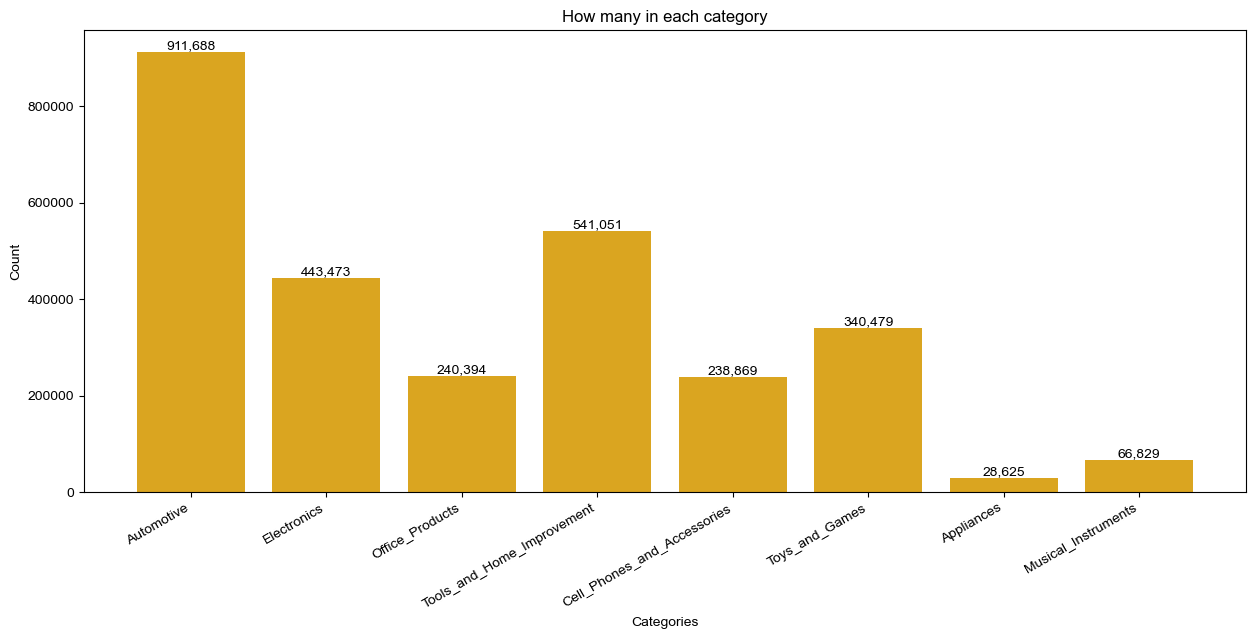

In [29]:
category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.figure(figsize=(15,6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value ilabel on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

## Objective

craft a dataset which is more balanced in terms of prices. Less heavily skewed to cheap items, with an average that's higher than $60. Try to balance out the categories - fewer Automotive items.

In [32]:
# Craft a dict with a key of each price from $1 to $999
# And in he value, put a list of items with that price (to nearest round number)

slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

In [41]:
# Create a dataset called "sample" which tries to more evenly take from the range of prices
# And gives more weight to items from categories other than Automotive
# Set randon seed for reproducibility
import numpy as np

np.random.seed(42)
random.seed(42)
sample = []
for i in range(1,1000):
    slot = slots[i]
    if i>=240:
        sample.extend(slot)
    elif len(slot) <= 1200:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected=[slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 408,635 items in the sample


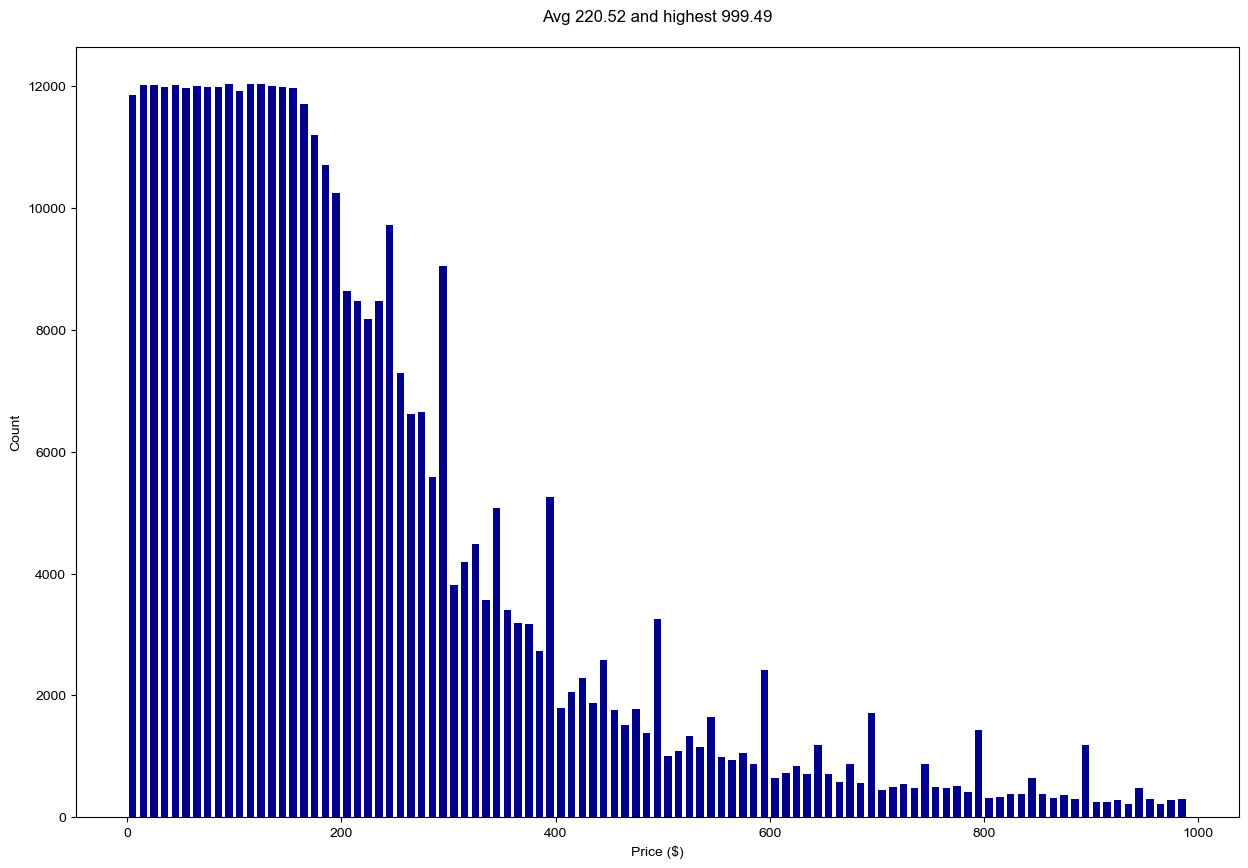

In [42]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

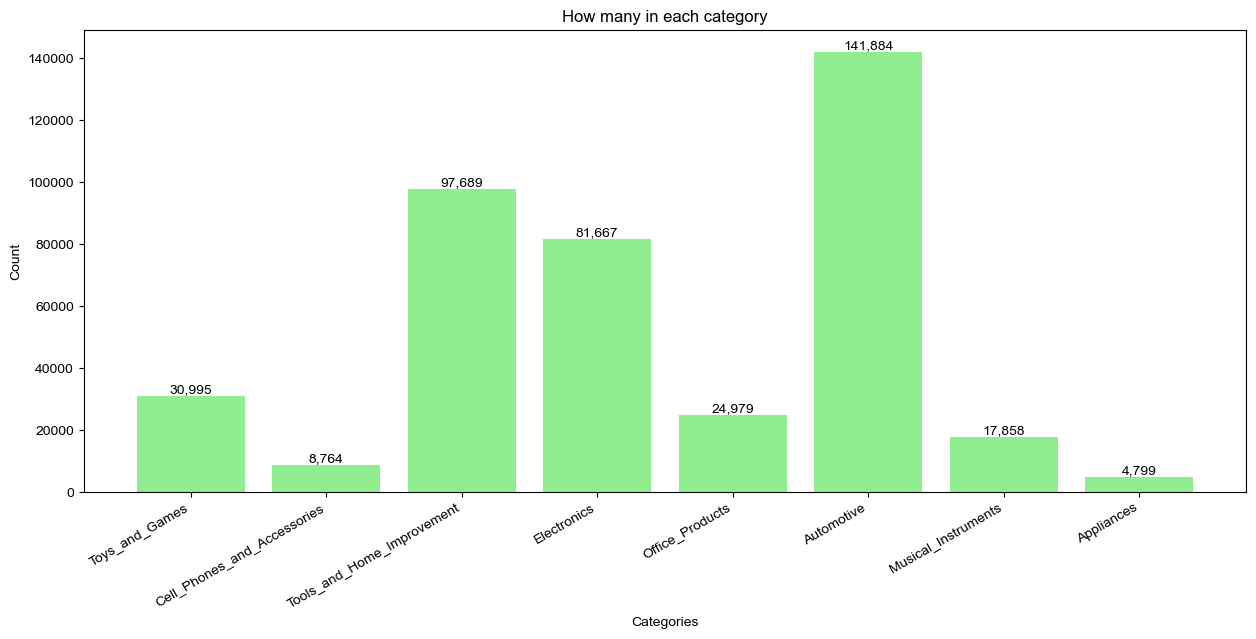

In [43]:
# OK, we did well in terms of raising the average price and having a smooth-ish population of prices
# Let's see the categories

category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

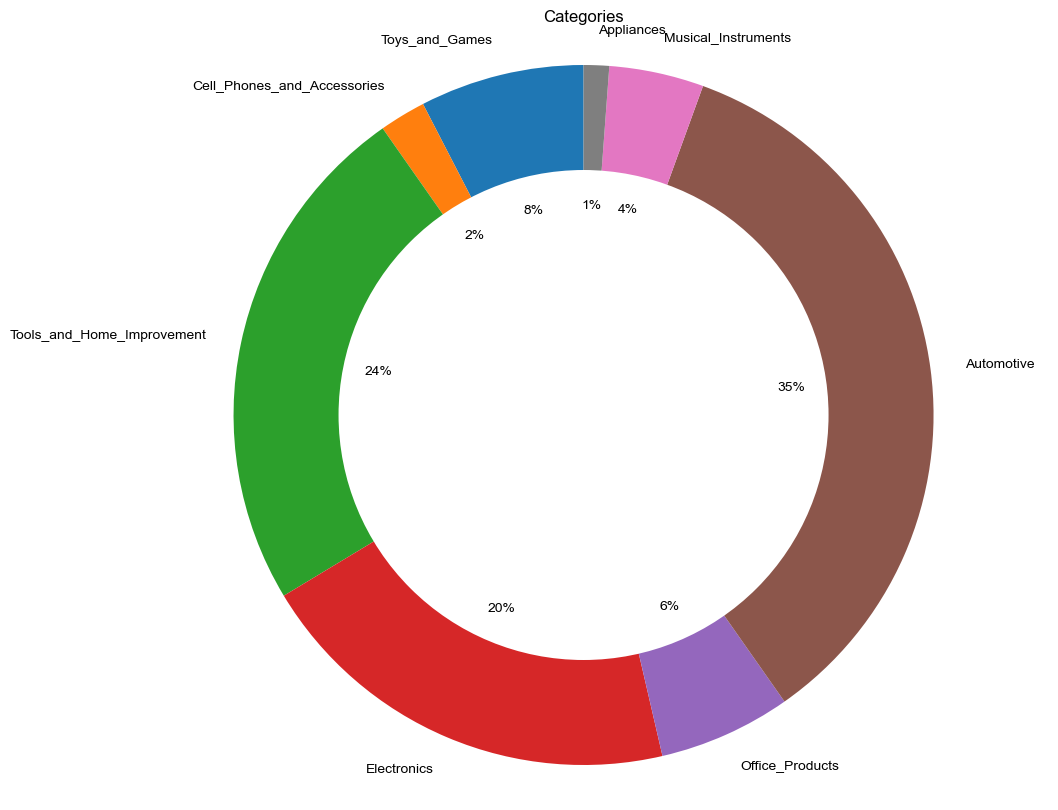

In [44]:
# Automotive still in the lead, but improved somewhat
# For another perspective, let's look at a pie

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.show()

# Dataset Curated!

We've crafted an excellent dataset.

Let's do some final checks

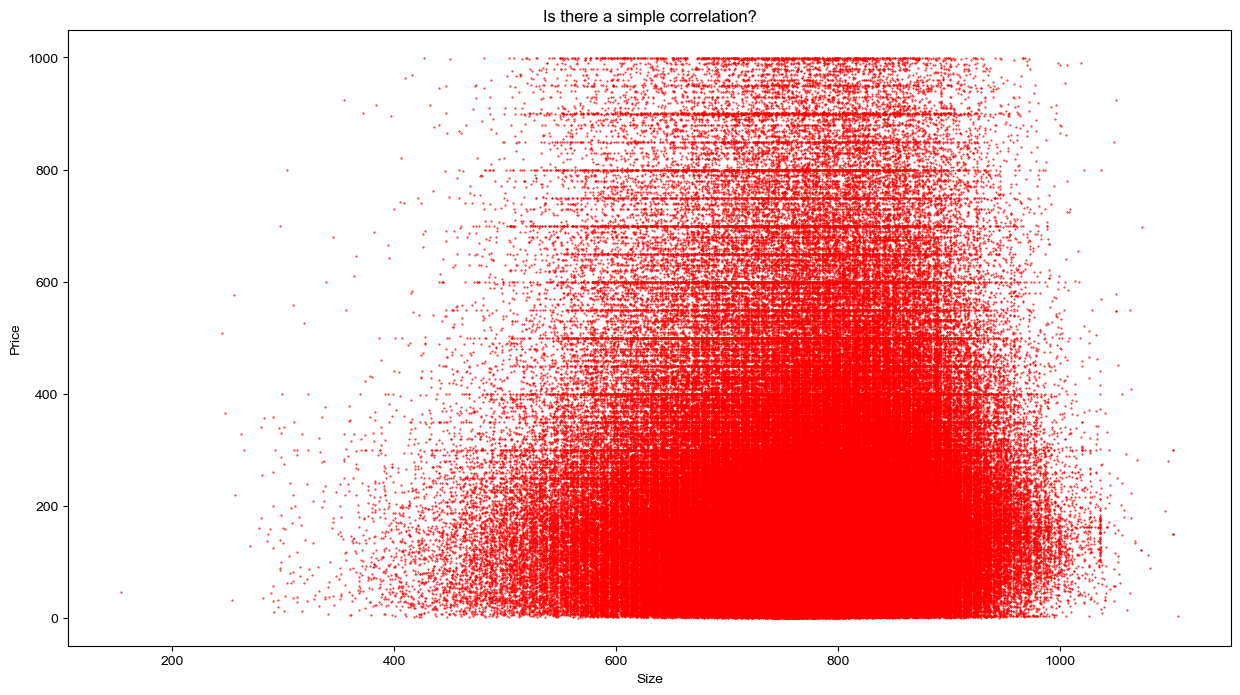

In [45]:
# How does the price vary with the character count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

In [46]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [53]:
report(sample[398000])

How much does this cost to the nearest dollar?

Precut Window Tint Kit for Hyundai Elentra 4 Sedan 2011 2012 2013 2014
Our high quality tint film includes a 5 year warranty. Our film when installed properly will not bubble, fade, or lose color. You may also request the third brake light cut out, only if it is available to us will we provide it. Computer precut window tint kit for all side and back windows not including windshield. Does not include installation tools, but is recommended for a successful installation. Third brake light cut out only on request and only if available to us. Tint shade can be changed between 5% 20% 35% and 50%. Includes installation instructions Manufacturer True Line, Rank Automotive Automobile Window Tinting Kits 115

Price is $49.00
[62993, 220, 7322, 271, 7117, 374, 400, 2491, 13, 410]
[' Kits', ' ', '115', '\n\n', 'Price', ' is', ' $', '49', '.', '00']


## Observation

An interesting thing about the Llama tokenizer is that every number from 1 to 999 gets mapped to 1 token, much as we saw with gpt-4o. The same is not true of qwen2, gemma and phi3, which all map individual digits to tokens. This does turn out to be a bit useful for our project, although it's not an essential requirement.

# Finally

It's time to break down our data into a training, test and validation dataset.

It's typical to use 5%-10% of your data for testing purposes, but actually we have far more than we need at this point. We'll take 400,000 points for training, and we'll reserve 2,000 for testing, although we won't use all of them.


In [48]:
random.seed(42)
random.shuffle(sample)
train = sample[:400_000]
test = sample[400_000:402_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 400,000 items and test set of 2,000 items


In [56]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

Delphi FG0166 Fuel Pump Module
Delphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7

Price is $227.00


In [57]:
print(test[5].test_prompt())

How much does this cost to the nearest dollar?

Horror Bookmarks, Resin Horror Bookmarks for Adults, The Best Gift for Fans of Horror Novels, Horror Personalized Bookmarks for Men Women, Horror Figures Sculpture Bookmarks (Set)
Horror Bookmarks - The Best Gift for Fans of Horror Novels, Resin Horror Bookmarks for Adults, Half-Length Figure Sculpture Bookmarks, Horror Bookmark Set for Men Women Office Supplies Specification Upper Part Material Resin Lower Part Of Material Wood Character Size 3.3cm x 2cm / x Overall Size 10cm / 4inch Package Includes 1 / 6 x Horror bookmarks - the best gift for fans of horror novels Note 1. Due to manual measurements, please allow slight measurement deviations. 2. Due to the different display and lighting effects, the

Price is $


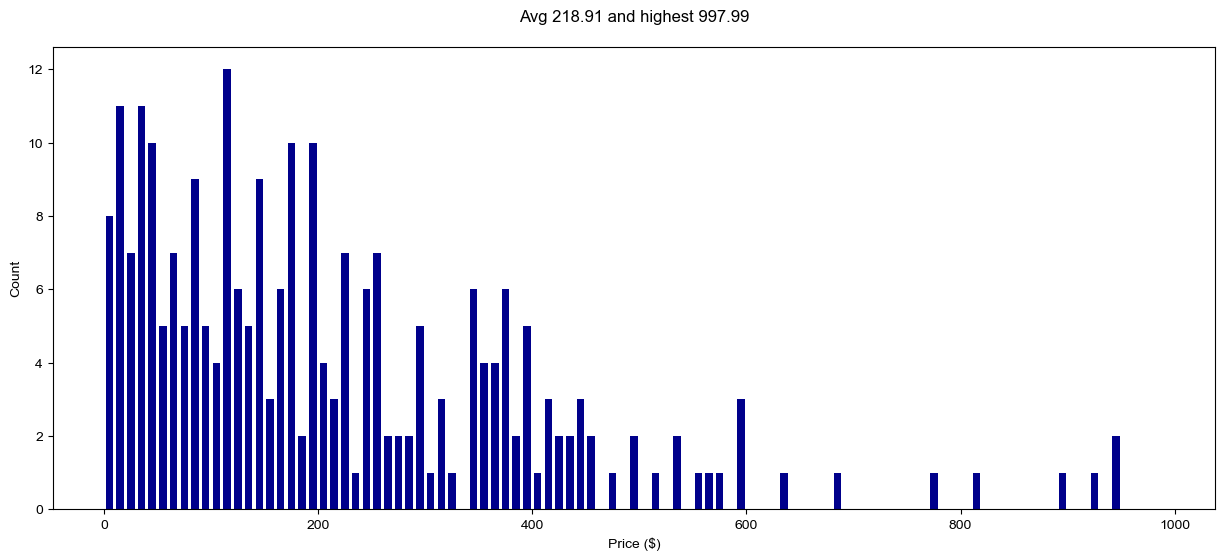

In [58]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

# Finally - upload your brand new dataset

Convert to prompts and upload to HuggingFace hub

In [65]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [66]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})

dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [69]:
DATASET_NAME = "AJ14314/pricer-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/400 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/AJ14314/pricer-data/commit/3bb5e80025c5992295c242e4e437fcbfbb0fe125', commit_message='Upload dataset', commit_description='', oid='3bb5e80025c5992295c242e4e437fcbfbb0fe125', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/AJ14314/pricer-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='AJ14314/pricer-data'), pr_revision=None, pr_num=None)

In [71]:
# One more thing!
# Let's pickle the training and test dataset so we don't have to execute all this code next time!

with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)